# Trade
- Swing trading/long-term trading
    - Exposed to overnight risk (close price previous day might not equal to open 
    price next day if there are major events happening between market closure and
    market open).
- Assume I already have which day to long, which day to short
- Conduct post-trade analysis
- Refine risk management techniques (Comparing starting on 2023-12-22)
    - Boeing: Main character in the events
        - Stock -18.61%

    - Direct competitors
        - Airbus (EPA: AIR): Boeing's primary competitor in commercial aircraft manufacturing
            - Stock +5.93%
        - Lockhead Martin (LMT): More focused on defense but also compete in aerospace
    - Suppliers
        - General Electric (GE): Supplies engines for Boeing aircraft
            - Have presence in aviation, healthcare, power, renewable energy
            - Doesn't seem to be affected
            - Can also supply engines to other aircraft manufacturers (effect on
            stock price is complicated)
    - Customers
        - Alaska Airlines (ALK): Main airline involved
            - Stock -11.73%
        - American Airlines (UAL - NasdaqGS)
            - Stock -4.91%
        - Delta Air Lines (DAL)
            - -11.73%
        - Southwest Airlines
- Trading timing (NYSE) vs news timing
    - The news was updated on January 18, 2024, at 4:36 AM GMT+8, which translates to January 17, 2024, at 3:36 PM Eastern Time (since GMT+8 is 13 hours ahead of Eastern Time). Since the NYSE closes at 4:00 PM ET, this news would have come out just before the market close.
    - Difference stock exchanges might operate at different timings also
- No training and validation - straight go to validation (backtesting)



In [1]:
import yfinance as yf
from backtesting import Backtest, Strategy
import pandas as pd
import numpy as np
import finnhub
from dotenv import load_dotenv
from pathlib import Path    
import sys
import time
sys.path.append('../') # Change the python path at runtime

# Self-created modules
from src.utils import path as path_yq

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
BACKTEST_START_DATE = '2023-11-01'
BACKTEST_END_DATE = '2024-01-31'

cur_dir = Path.cwd()
root_dir = path_yq.get_root_dir(cur_dir)

Similar to download data codes
TODO: Assumption: assume other stocks share the same timezone

In [28]:
# Define the ticker list
ticker_list = ['BA']

# Fetch the data
dl_data = yf.download(ticker_list, start=BACKTEST_START_DATE, end=BACKTEST_END_DATE) # Auto adjust is false

dl_data = pd.DataFrame(dl_data)
data = dl_data.drop(columns=['Close'], axis=1)
data = data.rename(columns={'Adj Close': 'Close'})
display(data.isna().sum(axis=0)) # Axis=0: along the indices, row-wise opertaion
# Gives the sum for rows in a column
data.index = pd.to_datetime(data.index)
data


[*********************100%%**********************]  1 of 1 completed


Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

,Open,High,Low,Close,Volume
Date,,,,,
2023-11-01,189.690002,190.779999,187.500000,189.380005,5832200
2023-11-02,190.899994,192.940002,190.339996,192.009995,4313000
2023-11-03,194.000000,197.139999,193.710007,195.050003,4483200
2023-11-06,195.880005,196.149994,192.460007,192.949997,4222200
2023-11-07,192.169998,192.169998,189.570007,191.410004,4012900
...,...,...,...,...,...
2024-01-24,209.830002,217.589996,209.360001,214.130005,15119100
2024-01-25,208.199997,208.729996,198.320007,201.880005,22112500
2024-01-26,203.080002,206.750000,203.000000,205.470001,9911200


In [29]:
dates = pd.DataFrame(data.index.strftime('%Y-%m-%d'))
# dates.to_csv("trading_dates.csv", index=False)

<Axes: >

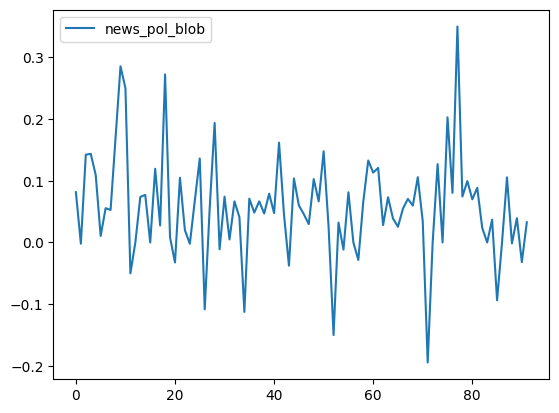

In [30]:
# After performing sentiment
stm_path = root_dir.joinpath('data', 'proc', 'boeing_stm_20231101_to_20240131.csv')
news = pd.read_csv(stm_path, index_col=False)
news2 = news[['datetime2', 'news_pol_blob']]
news2

news2.plot()
# # data['Sentiment'] = np.random.random(len(data)) * 2 - 1
# display(len(data))
# sentiment = np.array([0, -1, -0.8, 0, 0, 0]) # Put -1 on 01-05 (Before the whole thing Boeing case appeared after market closed on 01-05 to prepare to trade for 01-08)
# data['Sentiment'] = sentiment
# display(data.tail(20))

In [31]:
# Ensure datetime2 in news2 is in pandas datetime format
news2['datetime2'] = pd.to_datetime(news2['datetime2'])

# Assuming data.index is already a DatetimeIndex, no need to convert it again
# Just ensure it's sorted
data.sort_index(inplace=True)

# Function to find the closest previous date in data for each date in news2
def find_closest_previous_date(target_date, date_index):
    previous_dates = date_index[date_index <= target_date]
    if not previous_dates.empty:
        return previous_dates.max()
    else:
        return pd.NaT  # Return Not-A-Time (NaT) if no previous date is found

# Apply the function to each date in news2['datetime2']
closest_dates = news2['datetime2'].apply(lambda x: find_closest_previous_date(x, data.index))

# Add this closest date information to news2
news2['closest_date'] = closest_dates
news2

/var/folders/nw/_dsfxl1x5wl1p_pdmrb1y1hh0000gn/T/ipykernel_2253/1098752560.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news2['datetime2'] = pd.to_datetime(news2['datetime2'])
/var/folders/nw/_dsfxl1x5wl1p_pdmrb1y1hh0000gn/T/ipykernel_2253/1098752560.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news2['closest_date'] = closest_dates


,datetime2,news_pol_blob,closest_date
0,2024-01-31 23:20:26,0.081534,2024-01-30
1,2024-01-31 22:46:03,-0.002045,2024-01-30
2,2024-01-31 22:30:16,0.142258,2024-01-30
3,2024-01-31 22:05:46,0.143651,2024-01-30
4,2024-01-31 19:44:00,0.109366,2024-01-30
...,...,...,...
87,2024-01-29 09:41:30,0.105443,2024-01-29
88,2024-01-29 09:16:31,-0.001515,2024-01-29
89,2024-01-29 09:15:24,0.039324,2024-01-29
90,2024-01-29 07:16:19,-0.031818,2024-01-29


In [32]:
# TODO: Need to think of how to combine the data (might have many neutral etc.)
# as_index will retain closest_date
news3 = news2.groupby('closest_date', as_index=False)['news_pol_blob'].mean().reset_index(drop=True) 
news3

,closest_date,news_pol_blob
0,2024-01-29,0.058204
1,2024-01-30,0.057114


In [34]:
merged = pd.merge(data, news3, left_on='Date', right_on='closest_date', how='left')
merged

,Open,High,Low,Close,Volume,closest_date,news_pol_blob
0,189.690002,190.779999,187.500000,189.380005,5832200,NaT,NaN
1,190.899994,192.940002,190.339996,192.009995,4313000,NaT,NaN
2,194.000000,197.139999,193.710007,195.050003,4483200,NaT,NaN
3,195.880005,196.149994,192.460007,192.949997,4222200,NaT,NaN
4,192.169998,192.169998,189.570007,191.410004,4012900,NaT,NaN
...,...,...,...,...,...,...,...
56,209.830002,217.589996,209.360001,214.130005,15119100,NaT,NaN
57,208.199997,208.729996,198.320007,201.880005,22112500,NaT,NaN
58,203.080002,206.750000,203.000000,205.470001,9911200,NaT,NaN
59,206.059998,207.039993,203.850006,205.190002,7535400,2024-01-29,0.058204


In [44]:
# Clean for 2 lines only
merged2 = merged.dropna().reset_index(drop=True)
merged2

,Open,High,Low,Close,Volume,closest_date,news_pol_blob
0,206.059998,207.039993,203.850006,205.190002,7535400,2024-01-29,0.058204
1,203.649994,203.979996,199.139999,200.440002,13321200,2024-01-30,0.057114


# Backtesting
- Pros
    - Test single strategy
    - Have optimizer, graphs
- Cons
    - Cannot trade multiple assets FIXME: not applicable to portfolio
    - Does not trade fractional shares
https://kernc.github.io/backtesting.py/#example


- Other backtesting framework: backtrader, zipline - both can do multi-asset trading
- Backtrader works with Pandas DataFrames, CSV, and real-time data feeds from Interactive Brokers, Oanda, and Visual Chart. 

In [47]:
# TODO: Shift the polarity down or the date up (the data with today's date is the data from ytd)
# TODO: How to add the number of positions to put? Or leverage?
# Assume your data includes 'Open', 'Close', and 'Sentiment' columns
# data = pd.read_csv('your_stock_data.csv', parse_dates=True, index_col='Date')

class SentimentStrategy(Strategy):
    """
    """
    def init(self):
        super().init()
        # Initialize additional indicators here if needed

    def next(self):
        current_sentiment = self.data['news_pol_blob'][-1]
        print(self.data['closest_date'][-1])
        # Adding a hold condition
        # if -0.2 <= current_sentiment <= 0.2:
        #     return  # Hold if sentiment is within the range

        # Checking trade size (adjust as needed)
        trade_size = 1  # Example trade size, adjust based on your strategy

        # Trading logic based on sentiment score
        if current_sentiment > 0.05:  # Threshold for going long
            if not self.position or self.position.is_short:
                self.position.close()  # Close short position if any
                self.buy(size=trade_size)
                print(f"Buy on: {self.data.index[-1]}, Sentiment: {self.data['news_pol_blob'][-1]}")
        elif current_sentiment < -0.8:  # Threshold for going short
            if not self.position or self.position.is_long:
                self.position.close()  # Close long position if any
                self.sell(size=trade_size)
                # print(f"Sell on: {self.data.index[-1]}, Sentiment: {self.data.Sentiment[-1]}")

# Additional considerations
# 1. Slippage: Incorporate slippage into your trades, if your backtesting framework allows.
# 2. Execution Price: Decide whether to execute at the current day's close or the next day's open.
# 3. Risk Management: Implement risk management strategies like stop-loss orders.

# Running the backtest
bt = Backtest(data=merged2, 
              strategy=SentimentStrategy, 
              cash=10000, 
              margin=1,
              commission=.0,
              trade_on_close=False,
              hedging=True
              ) # TODO: Adjust commission
stats = bt.run()
# TODO: 
bt.optimize(maximise='SQN',
            method='grid',
            max_tries=None,
            constraint=None,
            return_heatmap=True,
            return_optimization=False # For the method 'skopt
            ) 
display(stats)
bt.plot() # TODO: Can have filename

# TODO: Change to use close instead of open, change html location

2024-01-30T00:00:00.000000000
Buy on: 1, Sentiment: 0.057113664331168115


/var/folders/nw/_dsfxl1x5wl1p_pdmrb1y1hh0000gn/T/ipykernel_2253/1554106988.py:38: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(merged2, SentimentStrategy, cash=10000, commission=.0) # TODO: Adjust commission


Start                                     0.0
End                                       1.0
Duration                                  1.0
Exposure Time [%]                         0.0
Equity Final [$]                  9996.790009
Equity Peak [$]                   9996.790009
Return [%]                                0.0
Buy & Hold Return [%]               -2.314928
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              NaN
Max. Drawdown [%]                        -0.0
Avg. Drawdown [%]                         NaN
Max. Drawdown Duration                    NaN
Avg. Drawdown Duration                    NaN
# Trades                                  0.0
Win Rate [%]                              NaN
Best Trade [%]                            NaN
Worst Trade [%]                           NaN
Avg. Trade [%]                    

/opt/homebrew/lib/python3.11/site-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_drag' property; using the latest value
  fig = gridplot(
/opt/homebrew/lib/python3.11/site-packages/backtesting/_plotting.py:659: UserWarning: found multiple competing values for 'toolbar.active_scroll' property; using the latest value
  fig = gridplot(


GridPlot(id='p1713', ...)